## Map County Level Data

## Overview 

Google Colab (Jupyter Notebook) provides tools to map data. Within Google Colab it is possible to read in Shapefiles, merge key variables and make a dynamic web based map to explore the data.

Basic steps
1. Review and attempt to replicate examples:
- Goodman, Cooper, Rosenheim, Nathanael, Day, Wayne, Gu, Donghwan, and Korukonda, Jayasaree. Population Distribution Workflow using Census API in Jupyter Notebook: Dynamic Map of Census Tracts in Boone County, KY, 2000. Ann Arbor, MI: Inter-university Consortium for Political and Social Research [distributor], 2020-07-31. https://doi.org/10.3886/E120382V1
- Rosenheim, Nathanael; Day, Wayne; Seong, Kijin (2021) “Automated Neighborhood Characteristics for Community Resilience Planning.” DesignSafe-CI. https://doi.org/10.17603/ds2-hj0p-bp40.
2. Open example Jupyter Notebook in Google Colab
3. Modify example notebook:
- Setup notebook enviroment 
  - Install packages
  - Set the working directory
- 1. Obtain data 
  - 1.1 Obtain the data you want to map
  - 1.2 Obtain the shapefile data for the map
- 2. Clean Data
  - 2.1 Merge shapefile and datafile
  - 2.2 Check variable to map
  - 2.2 Check map projection
- 3. Explore Data
  - 3.1 Setup map 


## Setup Notebook Enviroment 

### Install Packages

In [1]:
# Install packages not included in Google Colab
!pip install geopandas

     |████████████████████████████████| 1.0MB 9.0MB/s 
     |████████████████████████████████| 6.5MB 27.6MB/s 
     |████████████████████████████████| 15.3MB 326kB/s 


In [2]:
# Import packages
import sys  # For checking version of python for replication
import os # operating system package helps navigate folders
import pandas as pd # For reading, writing and wrangling data
import geopandas as gpd # For creating maps
import requests         # Required for the Census API
import folium as fm # For creating the final HTML map complete with OSM (Open Street Map) basemap
import numpy as np # the fundamental package for scientific computing with Python

In [3]:
# Display package versions - important information for replication
print("Python Version     ", sys.version)
print("pandas version:    ", pd.__version__)
print("geopandas version:    ", gpd.__version__)
print("numpy version:     ", np.__version__)
print("folium version:    ", fm.__version__)

Python Version      3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
pandas version:     1.1.5
geopandas version:     0.9.0
numpy version:      1.19.5
folium version:     0.8.3


### Set Working Directory
Google Colab is cloud based, but can be connected to your personal Google Drive account. The next lines mount the Google Drive and changes the current directory.

In [4]:
# What is the current workding directory?
os.getcwd()

'/content'

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# change the currect directory to the main project folder
os.chdir('/content/drive/Shareddrives/URSC689_S2021/Projects/TMPWF')

In [7]:
# List directories in the current folder
os.listdir()

['WorkNPR',
 'Admin',
 'Posted',
 'SourceData',
 'Readings',
 'Projects',
 'TMPWF_READ ME FIRST_2021-03-12.txt',
 'TMPWF_READ ME FIRST.gdoc',
 'WorkJB',
 'WorkDR',
 'WorkMCS',
 'WorkJRW',
 'WorkCIW',
 'WorkMU',
 'WorkMAH',
 'WorkSJ',
 'WorkJSLM',
 'WorkYD',
 'WorkJRB']

In [8]:
## What is your work folder named? Warning - name is case sensitive - be sure to capitalize
# The os.listdir command above shows the list of directories in the current directory
workfolder=input()

WorkNPR


In [9]:
# change the currect directory to the main project folder
os.chdir(workfolder)

In [10]:
os.getcwd()

'/content/drive/Shareddrives/URSC689_S2021/Projects/TMPWF/WorkNPR'

## Obtain Data
Maps require two pieces of information. First, the geographic details which are normally stored in a shapefile. Second, the key variables or information that are assocatied with the geogrpahic information. This section demonstrates how to bring the data into the Google Colab environment.

### 1.1 Obtain the data that you want to map

In [19]:
# Base API URL parameters, found at https://api.census.gov/data.html, refer to column names at the api.census.gov website
vintage = '2010'         # Census Year
dataset_name = 'dec/sf1' # Dataset Name
title = 'Decennial Census SF1'

# Geography paramaters
state = '48' # State FIPS Codes

# Variable parameters
get_vars = 'GEO_ID,NAME,P005001,P005003,P005004,P005010'

In [20]:
 # Set up hyperlink for Census API
api_hyperlink = ('https://api.census.gov/data/'+vintage+'/'+dataset_name+'?get='+get_vars+
                     '&in=state:'+state+'&for=county:*')
print("Census API data from: "+ api_hyperlink)

Census API data from: https://api.census.gov/data/2010/dec/sf1?get=GEO_ID,NAME,P005001,P005003,P005004,P005010&in=state:48&for=county:*


In [21]:
# Obtain Census API JSON Data
apijson = requests.get(api_hyperlink)

# Convert the requested json into pandas dataframe
apidf = pd.DataFrame(columns=apijson.json()[0], data=apijson.json()[1:])

# Add variable named "Survey" that identifies Census survey program and survey year
apidf['Survey'] = vintage+' '+title

In [22]:
apidf.head()

,GEO_ID,NAME,P005001,P005003,P005004,P005010,state,county,Survey
0,0500000US48023,"Baylor County, Texas",3726,3147,71,455,48,023,2010 Decennial Census SF1
1,0500000US48001,"Anderson County, Texas",58458,35792,12222,9287,48,001,2010 Decennial Census SF1
2,0500000US48007,"Aransas County, Texas",23158,16350,258,5690,48,007,2010 Decennial Census SF1
3,0500000US48003,"Andrews County, Texas",14786,7083,199,7195,48,003,2010 Decennial Census SF1
4,0500000US48005,"Angelina County, Texas",86771,54889,12840,17145,48,005,2010 Decennial Census SF1


In [23]:
data2map_df = apidf.copy()
data2map_df.head()

,GEO_ID,NAME,P005001,P005003,P005004,P005010,state,county,Survey
0,0500000US48023,"Baylor County, Texas",3726,3147,71,455,48,023,2010 Decennial Census SF1
1,0500000US48001,"Anderson County, Texas",58458,35792,12222,9287,48,001,2010 Decennial Census SF1
2,0500000US48007,"Aransas County, Texas",23158,16350,258,5690,48,007,2010 Decennial Census SF1
3,0500000US48003,"Andrews County, Texas",14786,7083,199,7195,48,003,2010 Decennial Census SF1
4,0500000US48005,"Angelina County, Texas",86771,54889,12840,17145,48,005,2010 Decennial Census SF1


### 1.2 Obtain the shapefile data for the map

In [26]:
sourcedata_folder = 'https://www2.census.gov/geo/tiger/GENZ2010/'

In [27]:
shapefile2map_gdf = gpd.read_file(sourcedata_folder+'gz_2010_us_050_00_5m.zip')

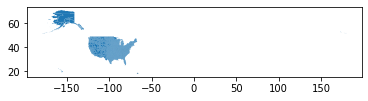

In [28]:
shapefile2map_gdf.plot()

In [29]:
shapefile2map_gdf.head()

,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,geometry
0,0500000US02261,02,261,Valdez-Cordova,CA,34239.880,"MULTIPOLYGON (((-147.48383 60.61864, -147.5000..."
1,0500000US02270,02,270,Wade Hampton,CA,17081.433,"POLYGON ((-162.58775 63.27573, -162.55188 63.2..."
2,0500000US02275,02,275,Wrangell,Cty&Bor,2541.483,"MULTIPOLYGON (((-132.56989 56.63350, -132.5703..."
3,0500000US02290,02,290,Yukon-Koyukuk,CA,145504.789,"POLYGON ((-141.00246 65.83942, -141.09244 65.8..."
4,0500000US04003,04,003,Cochise,County,6165.690,"POLYGON ((-109.04761 32.42638, -109.04829 32.0..."


## 2. Clean Data

### 2.1 Merge shapefile and datafile
The datafile and the shapefile must share a common unique id. Most likely this will be the FIPS code or GEO_ID provided. All US Census Geographies have a unique FIPS code.

In [30]:
# Join the shapefile and the CensusAPI dataset together
merge_gdf = pd.merge(shapefile2map_gdf, data2map_df, left_on='GEO_ID', right_on='GEO_ID')
# Check data
merge_gdf.head()

,GEO_ID,STATE,COUNTY,NAME_x,LSAD,CENSUSAREA,geometry,NAME_y,P005001,P005003,P005004,P005010,state,county,Survey
0,0500000US48173,48,173,Glasscock,County,900.218,"POLYGON ((-101.77580 31.65132, -101.77608 32.0...","Glasscock County, Texas",1226,825,15,378,48,173,2010 Decennial Census SF1
1,0500000US48175,48,175,Goliad,County,852.014,"POLYGON ((-97.57464 28.81330, -97.41734 28.925...","Goliad County, Texas",7210,4337,310,2462,48,175,2010 Decennial Census SF1
2,0500000US48179,48,179,Gray,County,925.974,"POLYGON ((-100.53898 35.18314, -101.08628 35.1...","Gray County, Texas",22535,15564,1055,5365,48,179,2010 Decennial Census SF1
3,0500000US48183,48,183,Gregg,County,273.303,"POLYGON ((-94.57922 32.39492, -94.59139 32.365...","Gregg County, Texas",121730,74005,24068,20018,48,183,2010 Decennial Census SF1
4,0500000US48189,48,189,Hale,County,1004.683,"POLYGON ((-102.09041 34.31313, -101.99802 34.3...","Hale County, Texas",36273,13647,1803,20269,48,189,2010 Decennial Census SF1


### 2.2 Check variable to map
The variable to me mapped needs to be a continous number.

In [31]:
merge_gdf['P005001'].describe()

count      254
unique     253
top       3719
freq         2
Name: P005001, dtype: object

In [32]:
# Convert variables from dtype object to integer
merge_gdf['Total Population'] = merge_gdf['P005001'].astype(int)

In [33]:
merge_gdf['Total Population'].describe()

count    2.540000e+02
mean     9.899827e+04
std      3.528918e+05
min      8.200000e+01
25%      6.748750e+03
50%      1.838100e+04
75%      4.943850e+04
max      4.092459e+06
Name: Total Population, dtype: float64

### 2.3 Check map projection
To map data the projection has to be in the correct format. This program uses Folium which uses the CRS EPSG=4326


In [34]:
# Check the original CRS information
merge_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands.  British Virgin Island

In [35]:
# Changing the CRS to Lat and Long with ESPG=4326
# We use .to_crs() and the EPSG unique ID to convert the CRS
merge_gdf = merge_gdf.to_crs(epsg=4326)
merge_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Explore Data

### 3.1 Setup map
To map the data Folium needs some basic information to determine where the map should be centered and what varaible will be mapped.

In [36]:
merge_gdf.bounds.head()

,minx,miny,maxx,maxy
0,-101.776085,31.650854,-101.264216,32.087532
1,-97.778530,28.388684,-97.158183,28.925228
2,-101.086281,35.182140,-100.538978,35.619296
3,-94.986935,32.360044,-94.579219,32.667557
4,-102.090415,33.824675,-101.563580,34.313132


In [37]:
# What location should the map be centered on?
center_x = (merge_gdf.bounds.minx.mean() + merge_gdf.bounds.maxx.mean())/2
center_y = (merge_gdf.bounds.miny.mean() + merge_gdf.bounds.maxy.mean())/2
print(f'The center of the data file is located at {center_x} {center_y}')

The center of the data file is located at -98.65343650093672 31.65686793099929


In [38]:
map = fm.Map(location=[center_y, center_x], zoom_start=6)

# Add Study Area Block Groups to Map
fm.Choropleth(
    geo_data = merge_gdf,
    data=merge_gdf,
    columns=['GEO_ID','Total Population'],
    key_on= 'feature.properties.GEO_ID',
    fill_color='YlGnBu',
    name = 'Total Population 2010',
    legend_name= 'Total Population 2010'
).add_to(map)
map

In [41]:
# The map can be saved as a HTML file 
map.save('TMWPF_3bv2_MappingCountyData_2021-05-07.html')

In [ ]:
# The map can be saved as a shapefile
# merge_gdf.to_file("TMWPF_3bv2_MappingCountyData_2021-05-07.shp")